In [1]:
N_sample = 100 # number of samples to keep from each chain

## imports

In [2]:
import lenstronomy

lenstronomy.__version__

'1.9.0'

In [3]:
import numpy as np
import os
import pickle
import copy
import time
import h5py
from pprint import pprint
import joblib
import gc

from lenstronomy.Util import util
from lenstronomy.Util import param_util
from lenstronomy.Workflow.fitting_sequence import FittingSequence
from lenstronomy.Plots.model_plot import ModelPlot
from lenstronomy.Plots import chain_plot
from lenstronomy.Sampling.parameters import Param
#from lenstronomy.Analysis.lens_analysis import LensAnalysis
from lenstronomy.Util import mask_util
from lenstronomy.LensModel.lens_model import LensModel
from lenstronomy.Data.coord_transforms import Coordinates
from lenstronomy.Util.util import array2image

import paperfig as pf
pf.set_fontscale(2.)

cwd = os.getcwd()
base_path, _ = os.path.split(cwd)
print('Base directory path:', base_path)

Base directory path: /Users/ajshajib/Research/time_delay_cosmography/J2038/WGD2038-4008/lenstronomy_modeling


In [4]:
gc.collect()

20

## functions

In [36]:
savefig = True

import matplotlib.pyplot as plt
import seaborn as sns
import paperfig as pf

pf.set_fontscale(2.)


In [6]:
import sys
sys.path.insert(0, './process_output')

# load necessary functions for BIC computation and unpickling composite model outputs
from output_class import *

# load output files

## load power-law model chains and process

In [7]:
powerlaw_files = [
    '2038_run145_0_0_0_0_0_shortened',
    '2038_run145_0_0_1_0_0_shortened',
    '2038_run145_0_0_2_0_0_shortened',
    '2038_run145_0_1_0_0_0_shortened',
    '2038_run145_0_1_1_0_0_shortened',
    '2038_run145_0_1_2_0_0_shortened',
    
    '2038_run146_0_0_0_0_0_shortened',
    '2038_run146_0_0_1_0_0_shortened',
    '2038_run146_0_0_2_0_0_shortened',
    '2038_run146_0_1_0_0_0_shortened',
    '2038_run146_0_1_1_0_0_shortened',
    '2038_run146_0_1_2_0_0_shortened',
]

In [8]:
powerlaw_bics = []
powerlaw_param_arrays = []
powerlaw_num_param_arrays = []
powerlaw_kwargs_models = []
powerlaw_kwargs_constraints = []
powerlaw_param_classes = []
powerlaw_lens_models = []
powerlaw_kwargs_likelihoods = []
powerlaw_multi_band_list = []

for job_name_out in powerlaw_files:
    output_temp = os.path.join(base_path, 'temp', job_name_out +'_out.txt')

    f = open(output_temp, 'rb')
    [input_, output_] = joblib.load(f)
    f.close()
    fitting_kwargs_list, kwargs_joint, kwargs_model, kwargs_constraints, kwargs_likelihood, kwargs_params, init_samples = input_
  
    kwargs_result, multi_band_list_out, fit_output, _ = output_
    multi_band_list = kwargs_joint['multi_band_list']

    samples_mcmc = fit_output[-1][1] #[np.random.randint(0, high=fit_output[-1][1].shape[0], size=N_sample)]
    param_mcmc = fit_output[-1][2]
    
    param_class = Param(kwargs_model,
                        kwargs_params['lens_model'][2], 
                        kwargs_params['source_model'][2],
                        kwargs_params['lens_light_model'][2],
                        kwargs_params['point_source_model'][2],
                        kwargs_lens_init=kwargs_params['lens_model'][0], #kwargs_result['kwargs_lens'],
                        **kwargs_constraints
                       )
    
    lens_model = LensModel(lens_model_list=kwargs_model['lens_model_list'],
                           z_lens=0.230, z_source=0.777,
                           multi_plane=False, #True, 
                          )
    
    num_data = np.sum([np.sum(m) for m in kwargs_likelihood['image_likelihood_mask_list']])
    num_param = param_class.num_param()[0] + param_class.num_param_linear()
    max_logL = np.max(fit_output[-1][-1])
    
    bic = compute_BIC(num_data, num_param, max_logL)
    
    powerlaw_bics.append(bic)
    powerlaw_param_arrays.append(np.copy(samples_mcmc))
    powerlaw_num_param_arrays.append(len(samples_mcmc))
    powerlaw_kwargs_models.append(kwargs_model)
    powerlaw_kwargs_constraints.append(kwargs_constraints)
    powerlaw_param_classes.append(param_class)
    powerlaw_lens_models.append(lens_model)
    powerlaw_kwargs_likelihoods.append(kwargs_likelihood)
    powerlaw_multi_band_list.append(multi_band_list_out)
    
    gc.collect()
    #break

In [9]:
powerlaw_bics

[27438.189734635733,
 26947.436735282005,
 26755.611915180907,
 29505.79676475082,
 29498.64039021145,
 29078.07576684941,
 27318.50045395967,
 26921.136693655084,
 26711.996990517746,
 29490.90135651526,
 29062.823276993124,
 28841.168230994306]

In [10]:
# power-law parameter numbers
for param_class in powerlaw_param_classes:
    print('non-linear: {}, linear: {}'.format(param_class.num_param()[0], param_class.num_param_linear()))

non-linear: 51, linear: 208
non-linear: 51, linear: 243
non-linear: 51, linear: 281
non-linear: 51, linear: 208
non-linear: 51, linear: 243
non-linear: 51, linear: 281
non-linear: 51, linear: 208
non-linear: 51, linear: 243
non-linear: 51, linear: 281
non-linear: 51, linear: 208
non-linear: 51, linear: 243
non-linear: 51, linear: 281


In [11]:
from lenstronomy.Analysis.td_cosmography import TDCosmography
from lenstronomy.Analysis.lens_profile import LensProfileAnalysis
from tqdm import tnrange

In [12]:
powerlaw_del_bics = np.max(powerlaw_bics) - np.array(powerlaw_bics)
powerlaw_weights = get_relative_weights(powerlaw_bics, 99.91711718678918, take_std=False, 
                                        sigma_model=325.16992966107614) #np.exp(powerlaw_del_logZs) / np.sum(np.exp(powerlaw_del_logZs))
#powerlaw_weights = [1.] * len(powerlaw_files)

print(powerlaw_weights)

[2.86574263e-01 7.28246686e-01 9.49597661e-01 5.38642055e-05
 4.06432244e-05 5.12655579e-04 3.73482639e-01 7.58460617e-01
 1.00000000e+00 5.40094135e-05 5.88064357e-04 1.84076448e-03]


In [53]:
from lenstronomy.Util.class_creator import create_im_sim
from lenstronomy.LightModel.light_model import LightModel


powerlaw_light_profile_shapes_ra = []
powerlaw_light_profile_shapes_dec = []

rs = np.linspace(0., 2.8, 280)


for n_job in tnrange(len(powerlaw_files), desc='Jobs:'):
    num_sample_from_job = int(powerlaw_num_param_arrays[n_job])
    
    td_cosmography = TDCosmography(z_lens=0.230, z_source=0.777, kwargs_model=powerlaw_kwargs_models[n_job])
    
    sampled_indices = np.random.randint(low=0, high=powerlaw_num_param_arrays[n_job], size=int(N_sample * powerlaw_weights[n_job]))
    
    lens_model = powerlaw_lens_models[n_job] #lens_analysis.LensModel
    lens_analysis = LensProfileAnalysis(powerlaw_lens_models[n_job])
    
    kwargs_model = powerlaw_kwargs_models[n_job]
    multi_band_list_out = powerlaw_multi_band_list[n_job]
    band_index = 2
    
    kwargs_likelihood = powerlaw_kwargs_likelihoods[n_job]
    
    powerlaw_light_profile_shape = []
  
    for i in tnrange(len(sampled_indices), desc='Sample from job {:d}:'.format(n_job)): #len(samples_mcmc)):
        param_array = powerlaw_param_arrays[n_job][sampled_indices[i]]

        param_class = powerlaw_param_classes[n_job]

        kwargs_data = multi_band_list_out[band_index][0]
        kwargs_psf = multi_band_list_out[band_index][1]
        kwargs_numerics = multi_band_list_out[band_index][2]

        im_sim = create_im_sim(multi_band_list_out,
                                    'multi-linear',
                                    kwargs_model,
                                    bands_compute=None,
                                    likelihood_mask_list=kwargs_likelihood['image_likelihood_mask_list'],
                                    band_index=band_index)
        
        kwargs_result = param_class.args2kwargs(param_array)
        im_sim.image_linear_solve(**kwargs_result, inv_bool=True)
            
        lens_result = kwargs_result['kwargs_lens']
        lens_light_result = kwargs_result['kwargs_lens_light']
        source_result = kwargs_result['kwargs_source']
        ps_result = kwargs_result['kwargs_ps']
        
        phi, q = param_util.ellipticity2phi_q(lens_result[0]['e1'],
                                      lens_result[0]['e2'])
        
        #x, y = rs * np.cos(phi + np.pi/4), rs * np.sin(phi + np.pi/4)
        x, y = rs, rs * 0.
        
        light_indices = kwargs_model['index_lens_light_model_list'][band_index]
        light_model_list = [kwargs_model['lens_light_model_list'][i] for i in light_indices]
        
        light_model = LightModel(light_model_list)
        
        
        kwargs_light = [lens_light_result[i] for i in light_indices]
        powerlaw_light_profile_shapes_ra.append(light_model.surface_brightness(x, y, kwargs_light))
        
        x, y = rs * 0., rs
        
        light_indices = kwargs_model['index_lens_light_model_list'][band_index]
        light_model_list = [kwargs_model['lens_light_model_list'][i] for i in light_indices]
        
        light_model = LightModel(light_model_list)
        
        
        kwargs_light = [lens_light_result[i] for i in light_indices]
        powerlaw_light_profile_shapes_dec.append(light_model.surface_brightness(x, y, kwargs_light))
        
        
#        powerlaw_light_profile_shape = lens_analysis.
#         powerlaw_theta_e.append(lens_result[0]['theta_E'])
#         powerlaw_gamma.append(lens_result[0]['gamma'])
        
        
#    powerlaw_light_profile_shapes.append(powerlaw_light_profile_shape)

/Users/ajshajib/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:11: TqdmDeprecationWarning: Please use `tqdm.notebook.trange` instead of `tqdm.tnrange`
  # This is added back by InteractiveShellApp.init_path()


Jobs::   0%|          | 0/12 [00:00<?, ?it/s]

/Users/ajshajib/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:29: TqdmDeprecationWarning: Please use `tqdm.notebook.trange` instead of `tqdm.tnrange`


Sample from job 0::   0%|          | 0/28 [00:00<?, ?it/s]

Sample from job 1::   0%|          | 0/72 [00:00<?, ?it/s]

Sample from job 2::   0%|          | 0/94 [00:00<?, ?it/s]

Sample from job 3:: 0it [00:00, ?it/s]

Sample from job 4:: 0it [00:00, ?it/s]

Sample from job 5:: 0it [00:00, ?it/s]

Sample from job 6::   0%|          | 0/37 [00:00<?, ?it/s]

Sample from job 7::   0%|          | 0/75 [00:00<?, ?it/s]

Sample from job 8::   0%|          | 0/100 [00:00<?, ?it/s]

Sample from job 9:: 0it [00:00, ?it/s]

Sample from job 10:: 0it [00:00, ?it/s]

Sample from job 11:: 0it [00:00, ?it/s]

In [54]:
import pandas as pd

glee_profile_ra = pd.read_csv('../model_posteriors/glee_2038_radial_light_profile_W.csv')
glee_profile_dec = pd.read_csv('../model_posteriors/glee_2038_radial_light_profile_N.csv')

In [55]:
glee_profile_ra

,r,light_pl_475,light_pl_814,light_pl_160,light_comp_475,light_comp_814,light_comp_160
0,0.00,0.971020,1.953211,29.628902,1.009229,1.933657,28.409430
1,0.01,0.962382,1.946497,29.526733,1.000708,1.930738,28.336782
2,0.02,0.935036,1.912063,29.319075,0.970272,1.901160,28.183524
3,0.03,0.894750,1.855303,29.005297,0.924846,1.849482,27.949312
4,0.04,0.847510,1.781626,28.585015,0.871619,1.780298,27.633947
...,...,...,...,...,...,...,...
276,2.76,0.008839,0.019862,0.505407,0.009015,0.020525,0.509513
277,2.77,0.008744,0.019655,0.502040,0.008917,0.020315,0.506425
278,2.78,0.008636,0.019422,0.499837,0.008806,0.020078,0.504406
279,2.79,0.008514,0.019199,0.499047,0.008681,0.019853,0.503682


In [69]:
amps = np.array([ 109.71266358,  794.93301916, 1532.92674307, 2512.27225728,
         802.3082921 , 1541.40433211, 2247.26031178, 3461.27666923,
        1438.18065661])
sigmas = np.array([ 0.11148307,  0.2444676 ,  0.52249641,  1.04108547,  2.20575275,
         2.21091594,  3.72653489,  8.49165874, 10.99787672])
    
mge_profile = 0.

xs = np.logspace(-2.5, 1.5, 1000)

for a, s in zip(amps, sigmas):
    mge_profile += a / (2*np.pi) / s**2 * np.exp(-xs**2/2./s**2) * 0.08**2

#amp = interp1d(xs, mge_profile)(3.2) * 8.

isophote_intensity = np.array([2.81674395e+01, 2.80241003e+01, 2.79376548e+01, 2.76640070e+01,
       2.73205135e+01, 2.69109445e+01, 2.65524359e+01, 2.63234559e+01,
       2.61003984e+01, 2.57406847e+01, 2.53513680e+01, 2.48909097e+01,
       2.43021945e+01, 2.36588153e+01, 2.29707524e+01, 2.22451540e+01,
       2.15400730e+01, 2.07415821e+01, 1.99374879e+01, 1.88695315e+01,
       1.77770359e+01, 1.66502970e+01, 1.56436536e+01, 1.44859412e+01,
       1.33254826e+01, 1.21847738e+01, 1.10139487e+01, 9.99849327e+00,
       8.97374038e+00, 8.03202159e+00, 7.10128401e+00, 6.18937208e+00,
       5.41697295e+00, 4.70240938e+00, 4.03017982e+00, 3.42997255e+00,
       3.04799056e+00, 3.00171312e+00, 2.44105927e+00, 1.80370421e+00,
       1.54964383e+00, 1.36756897e+00, 1.13430798e+00, 9.84463155e-01,
       8.27425112e-01, 6.94655303e-01, 5.82004736e-01, 4.86960530e-01,
       4.08075673e-01, 3.37802253e-01, 2.85625896e-01, 2.40198604e-01,
       2.09867513e-01, 1.82181829e-01, 1.52603805e-01, 1.19826501e-01,
       9.70260012e-02, 7.95500478e-02, 6.81121601e-02, 6.00368136e-02,
       5.03291831e-02, 3.85513013e-02, 3.32596003e-02, 2.90814516e-02,
       2.23873108e-02, 1.77987097e-02, 1.39330881e-02, 1.00113482e-02,
       7.01918292e-03, 5.42133087e-03, 4.19826941e-03])

isophote_intensity_error = np.array([0.        , 0.00574245, 0.01188524, 0.03156116, 0.04193748,
       0.0536408 , 0.04996095, 0.05266414, 0.07238149, 0.06346388,
       0.06492183, 0.06970633, 0.0636235 , 0.06418433, 0.06599174,
       0.05704632, 0.05398294, 0.0515921 , 0.04574281, 0.02288327,
       0.02000093, 0.02303395, 0.02613524, 0.02107169, 0.02213201,
       0.02157028, 0.01916878, 0.01388   , 0.01319626, 0.01111101,
       0.00981156, 0.01179084, 0.00655008, 0.00820663, 0.00967259,
       0.01268297, 0.02594064, 0.06587547, 0.03746649, 0.01448655,
       0.02300083, 0.0180416 , 0.00799866, 0.00764895, 0.0050912 ,
       0.00396138, 0.00306038, 0.00203216, 0.001653  , 0.00144987,
       0.00118027, 0.00112279, 0.00127357, 0.0008839 , 0.00081083,
       0.00053862, 0.000557  , 0.00047287, 0.00044553, 0.00044298,
       0.0005861 , 0.000408  , 0.00052336, 0.00061238, 0.00035364,
       0.00026787, 0.00020575, 0.00021654, 0.00019584, 0.00019115,
       0.00017079])

isophote_r = np.array([0.00000000e+00, 1.86065920e-01, 2.37295337e-01, 3.67813481e-01,
       5.03628292e-01, 6.43280489e-01, 7.48321392e-01, 8.21033465e-01,
       8.89143806e-01, 9.76371434e-01, 1.06646489e+00, 1.16832942e+00,
       1.28849135e+00, 1.42064486e+00, 1.56197937e+00, 1.70767846e+00,
       1.86021302e+00, 2.03406115e+00, 2.20326176e+00, 2.42183240e+00,
       2.65492841e+00, 2.90810204e+00, 3.16905497e+00, 3.47181721e+00,
       3.81280580e+00, 4.18338109e+00, 4.59438003e+00, 5.01392427e+00,
       5.49652467e+00, 6.01711387e+00, 6.59932646e+00, 7.27461282e+00,
       8.02031940e+00, 8.87208933e+00, 9.82524169e+00, 1.09336657e+01,
       1.19017311e+01, 1.24267750e+01, 1.40392760e+01, 1.64870054e+01,
       1.81357060e+01, 1.99492766e+01, 2.19590749e+01, 2.39588680e+01,
       2.64394268e+01, 2.90708671e+01, 3.19779538e+01, 3.50589844e+01,
       3.83696540e+01, 4.24385775e+01, 4.63596062e+01, 5.11263215e+01,
       5.56717815e+01, 6.04209085e+01, 6.62256080e+01, 7.36358778e+01,
       8.09080359e+01, 8.77657241e+01, 9.52988370e+01, 1.02375723e+02,
       1.12063918e+02, 1.24029703e+02, 1.34567850e+02, 1.46001962e+02,
       1.58627003e+02, 1.72303813e+02, 1.87616130e+02, 2.09023959e+02,
       2.34113805e+02, 2.54179001e+02, 2.72434313e+02]) * 0.08

(406, 280)
(406, 280)


<ErrorbarContainer object of 3 artists>

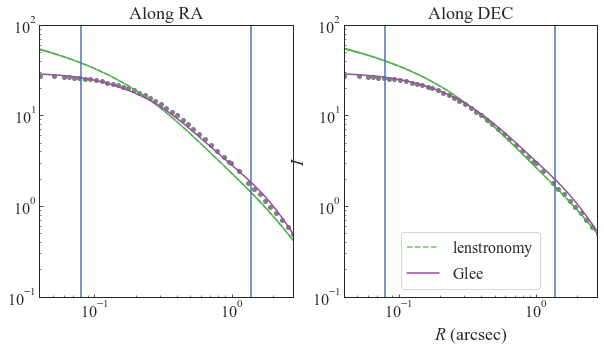

In [74]:
import matplotlib.pyplot as plt

tidied_light_profiles_ra = powerlaw_light_profile_shapes_ra #[]
tidied_light_profiles_dec = powerlaw_light_profile_shapes_dec #[]

# for j in powerlaw_light_profile_shapes_ra:
#     for s in j:
#         tidied_light_profiles_ra.append(s)

# for j in powerlaw_light_profile_shapes_dec:
#     for s in j:
#         tidied_light_profiles_dec.append(s)

fig = plt.figure(figsize=(10, 5))
        
####
ax = fig.add_subplot(121)
print(np.array(tidied_light_profiles_ra).shape)
sersic_upper_quantile, sersic_median, sersic_lower_quantile  = np.percentile(tidied_light_profiles_ra, q=[84, 50, 16], 
                                                                             axis=0)
        
        
        
ax.fill_between(rs, sersic_upper_quantile * 0.08**2, sersic_lower_quantile * 0.08**2, alpha=0.8, color=pf.cb_green, 
                label='Sersic fit')
ax.plot(rs, sersic_median * 0.08**2, alpha=0.8, color=pf.cb_green, 
        ls='--', label=r'Triple S${\rm \'e}$rsic fit')

ax.set_yscale('log')
ax.set_xscale('log')
ax.set_xlim(0.04, 2.8)

ax.axvline(1.38)
ax.axvline(0.08)

ax.plot(glee_profile_ra['r'], glee_profile_ra['light_pl_160'], color=pf.cb_purple);
ax.set_title('Along RA')

ax.errorbar(isophote_r, isophote_intensity, yerr=isophote_intensity_error, c='grey', ls='None', 
            marker='o', markersize=4, label='Isophotal fit', zorder=-10)

ax.set_ylim(1e-1, 1e2)
####
ax = fig.add_subplot(122)
print(np.array(tidied_light_profiles_dec).shape)
sersic_upper_quantile, sersic_median, sersic_lower_quantile  = np.percentile(tidied_light_profiles_dec, q=[84, 50, 16], 
                                                                             axis=0)
        
        
        
ax.fill_between(rs, sersic_upper_quantile * 0.08**2, sersic_lower_quantile * 0.08**2, alpha=0.8, color=pf.cb_green, 
                #label=r'$\textsc{lenstronomy}$'
               )
ax.plot(rs, sersic_median * 0.08**2, alpha=0.8, color=pf.cb_green, 
        ls='--', label=r'${\rm lenstronomy}$'
       )

ax.set_yscale('log')
ax.set_xscale('log')
ax.set_xlim(0.04, 2.8)

ax.plot(glee_profile_dec['r'], glee_profile_dec['light_pl_160'], color=pf.cb_purple, label=r'${\rm Glee}$');

ax.axvline(1.38)
ax.axvline(0.08)
ax.set_ylim(1e-1, 1e2)

ax.set_xlabel(r'$R$ (arcsec)')
ax.set_ylabel(r'$I$')
ax.set_title('Along DEC')
ax.legend()

ax.errorbar(isophote_r, isophote_intensity, yerr=isophote_intensity_error, c='grey', ls='None', 
            marker='o', markersize=4, label='Isophotal fit', zorder=-10)
### 
